## Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.ndimage.filters import uniform_filter1d
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPool1D, Dense, Dropout, Flatten, \
BatchNormalization, Input, concatenate, Activation
from keras.optimizers import Adam
import warnings
warnings.filterwarnings("always")

/tmp/ipykernel_36/562784492.py:8: DeprecationWarning: Please import `uniform_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import uniform_filter1d


## Loading the Data

In [3]:
train_df = pd.read_csv("/kaggle/input/exoTrain.csv")
test_df = pd.read_csv("/kaggle/input/exoTest.csv")

In [4]:
train_df.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [5]:
test_df.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,119.88,100.21,86.46,48.68,46.12,39.39,18.57,6.98,6.63,...,14.52,19.29,14.44,-1.62,13.33,45.50,31.93,35.78,269.43,57.72
1,2,5736.59,5699.98,5717.16,5692.73,5663.83,5631.16,5626.39,5569.47,5550.44,...,-581.91,-984.09,-1230.89,-1600.45,-1824.53,-2061.17,-2265.98,-2366.19,-2294.86,-2034.72
2,2,844.48,817.49,770.07,675.01,605.52,499.45,440.77,362.95,207.27,...,17.82,-51.66,-48.29,-59.99,-82.10,-174.54,-95.23,-162.68,-36.79,30.63
3,2,-826.00,-827.31,-846.12,-836.03,-745.50,-784.69,-791.22,-746.50,-709.53,...,122.34,93.03,93.03,68.81,9.81,20.75,20.25,-120.81,-257.56,-215.41
4,2,-39.57,-15.88,-9.16,-6.37,-16.13,-24.05,-0.90,-45.20,-5.04,...,-37.87,-61.85,-27.15,-21.18,-33.76,-85.34,-81.46,-61.98,-69.34,-17.84


## Understanding the Data

In [7]:
print(f"Shape of Training Data: {train_df.shape}")
print(f"Shape of Test Data: {test_df.shape}")

Shape of Training Data: (5087, 3198)
Shape of Test Data: (570, 3198)


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5087 entries, 0 to 5086
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 124.1 MB


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570 entries, 0 to 569
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 13.9 MB


In [10]:
train_df.describe()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
count,5087.000000,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,...,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5087.000000,5087.000000,5087.000000,5087.000000
mean,1.007273,1.445054e+02,1.285778e+02,1.471348e+02,1.561512e+02,1.561477e+02,1.469646e+02,1.168380e+02,1.144983e+02,1.228639e+02,...,3.485578e+02,4.956476e+02,6.711211e+02,7.468790e+02,6.937372e+02,6.553031e+02,-494.784966,-544.594264,-440.239100,-300.536399
std,0.084982,2.150669e+04,2.179717e+04,2.191309e+04,2.223366e+04,2.308448e+04,2.410567e+04,2.414109e+04,2.290691e+04,2.102681e+04,...,2.864786e+04,3.551876e+04,4.349963e+04,4.981375e+04,5.087103e+04,5.339979e+04,17844.469520,17722.339334,16273.406292,14459.795577
min,1.000000,-2.278563e+05,-3.154408e+05,-2.840018e+05,-2.340069e+05,-4.231956e+05,-5.975521e+05,-6.724046e+05,-5.790136e+05,-3.973882e+05,...,-3.240480e+05,-3.045540e+05,-2.933140e+05,-2.838420e+05,-3.288214e+05,-5.028894e+05,-775322.000000,-732006.000000,-700992.000000,-643170.000000
25%,1.000000,-4.234000e+01,-3.952000e+01,-3.850500e+01,-3.505000e+01,-3.195500e+01,-3.338000e+01,-2.813000e+01,-2.784000e+01,-2.683500e+01,...,-1.760000e+01,-1.948500e+01,-1.757000e+01,-2.076000e+01,-2.226000e+01,-2.440500e+01,-26.760000,-24.065000,-21.135000,-19.820000
50%,1.000000,-7.100000e-01,-8.900000e-01,-7.400000e-01,-4.000000e-01,-6.100000e-01,-1.030000e+00,-8.700000e-01,-6.600000e-01,-5.600000e-01,...,2.600000e+00,2.680000e+00,3.050000e+00,3.590000e+00,3.230000e+00,3.500000e+00,-0.680000,0.360000,0.900000,1.430000
75%,1.000000,4.825500e+01,4.428500e+01,4.232500e+01,3.976500e+01,3.975000e+01,3.514000e+01,3.406000e+01,3.170000e+01,3.045500e+01,...,2.211000e+01,2.235000e+01,2.639500e+01,2.909000e+01,2.780000e+01,3.085500e+01,18.175000,18.770000,19.465000,20.280000
max,2.000000,1.439240e+06,1.453319e+06,1.468429e+06,1.495750e+06,1.510937e+06,1.508152e+06,1.465743e+06,1.416827e+06,1.342888e+06,...,1.779338e+06,2.379227e+06,2.992070e+06,3.434973e+06,3.481220e+06,3.616292e+06,288607.500000,215972.000000,207590.000000,211302.000000


In [12]:
test_df.describe()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
count,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,...,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000
mean,1.008772,515.411351,738.046404,532.603246,739.618088,530.949807,729.591491,517.421404,720.723544,481.015211,...,60.027754,307.682825,88.976842,301.299895,105.121684,291.509561,256.656789,121.810035,224.806035,133.954544
std,0.093329,12592.950138,12622.940170,12545.065255,12591.933126,12512.976544,12572.187328,12454.094432,12525.496793,12397.610716,...,9528.594808,9588.586341,9497.373179,9611.024800,9611.076529,9654.581767,9362.719825,9487.642217,9483.948248,9700.731923
min,1.000000,-59421.000000,-14663.430000,-56580.000000,-10817.590000,-54545.000000,-7744.500000,-53580.000000,-6373.400000,-53832.000000,...,-89126.500000,-89432.070000,-89759.940000,-90182.630000,-90225.760000,-90595.000000,-86719.070000,-86911.500000,-87123.260000,-87476.940000
25%,1.000000,-22.230000,-22.912500,-22.985000,-18.662500,-20.980000,-21.245000,-22.675000,-22.200000,-22.685000,...,-9.602500,-12.842500,-15.222500,-14.350000,-17.370000,-18.272500,-24.000000,-27.360000,-36.855000,-29.475000
50%,1.000000,1.195000,0.410000,-1.125000,-0.880000,-1.495000,-2.650000,-4.330000,-3.910000,-3.890000,...,3.585000,3.795000,4.785000,3.910000,5.575000,7.150000,-4.385000,-4.995000,-5.135000,-3.785000
75%,1.000000,98.317500,89.710000,89.827500,73.257500,66.947500,45.147500,38.850000,37.150000,30.670000,...,23.445000,20.472500,25.582500,28.767500,27.455000,35.810000,17.755000,11.745000,12.265000,13.205000
max,2.000000,290882.500000,290653.500000,290554.000000,290486.500000,290289.000000,289982.500000,289197.500000,288520.500000,287404.500000,...,198420.000000,197888.500000,199639.000000,202007.000000,203730.500000,205924.000000,203193.000000,205050.000000,206884.500000,211488.500000


In [13]:
train_df.isnull().sum()

LABEL        0
FLUX.1       0
FLUX.2       0
FLUX.3       0
FLUX.4       0
            ..
FLUX.3193    0
FLUX.3194    0
FLUX.3195    0
FLUX.3196    0
FLUX.3197    0
Length: 3198, dtype: int64

In [14]:
test_df.isnull().sum()

LABEL        0
FLUX.1       0
FLUX.2       0
FLUX.3       0
FLUX.4       0
            ..
FLUX.3193    0
FLUX.3194    0
FLUX.3195    0
FLUX.3196    0
FLUX.3197    0
Length: 3198, dtype: int64

## Exploratory Data Analysis (EDA)

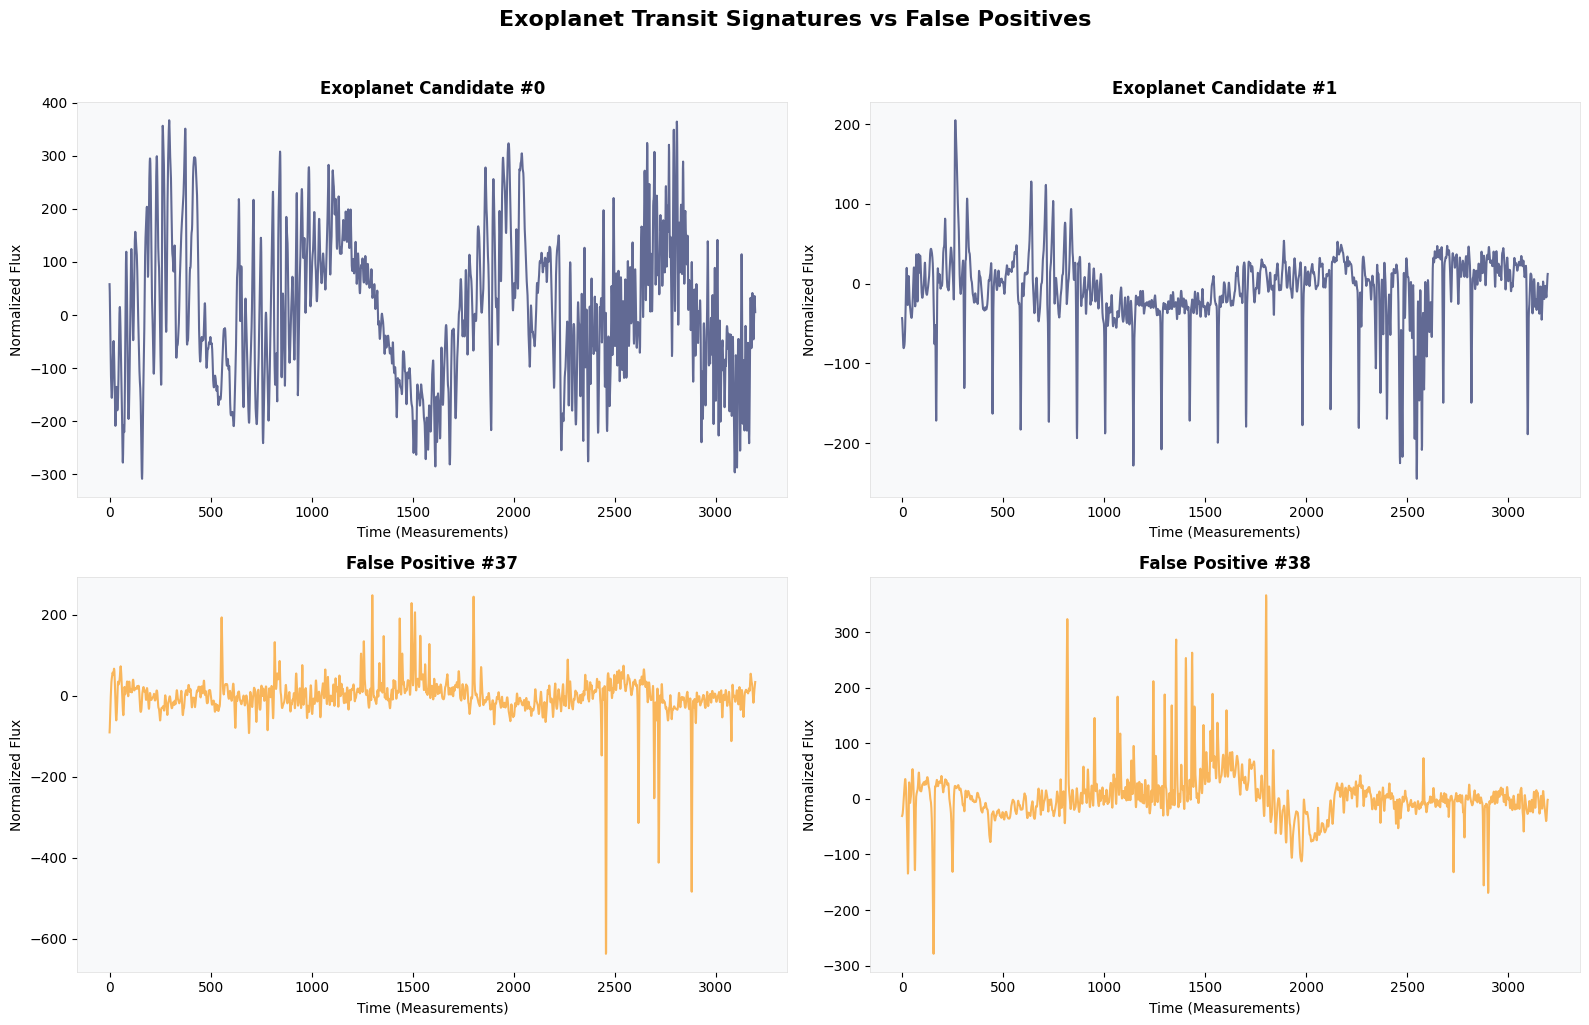

In [23]:
plt.style.use('default')
sns.set_palette("husl")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Exoplanet Transit Signatures vs False Positives', 
             fontsize=16, y=1.02, fontweight='bold')

exoplanet_color = '#3C467B'  
false_positive_color = '#FAA533'  

candidate_indices = train_df[train_df['LABEL'] == 2].index[:2]
fp_indices = train_df[train_df['LABEL'] == 1].index[:2]

for i, idx in enumerate(candidate_indices):
    flux_values = train_df.loc[idx, 'FLUX.1':'FLUX.3197'].values
    
    from scipy.ndimage import gaussian_filter1d
    smoothed_flux = gaussian_filter1d(flux_values, sigma=2)
    
    axes[0, i].plot(smoothed_flux, color=exoplanet_color, linewidth=1.5, alpha=0.8)
    axes[0, i].set_title(f'Exoplanet Candidate #{idx}', fontweight='bold', fontsize=12)
    axes[0, i].set_ylabel('Normalized Flux', fontsize=10)
    axes[0, i].set_xlabel('Time (Measurements)', fontsize=10)
    
    # axes[0, i].grid(True, alpha=0.3, linestyle='--')
    axes[0, i].set_facecolor('#f8f9fa')
    for spine in axes[0, i].spines.values():
        spine.set_color('#dddddd')
        spine.set_linewidth(0.5)

for i, idx in enumerate(fp_indices):
    flux_values = train_df.loc[idx, 'FLUX.1':'FLUX.3197'].values
    smoothed_flux = gaussian_filter1d(flux_values, sigma=2)
    
    axes[1, i].plot(smoothed_flux, color=false_positive_color, linewidth=1.5, alpha=0.8)
    axes[1, i].set_title(f'False Positive #{idx}', fontweight='bold', fontsize=12)
    axes[1, i].set_ylabel('Normalized Flux', fontsize=10)
    axes[1, i].set_xlabel('Time (Measurements)', fontsize=10)
    
    # axes[1, i].grid(True, alpha=0.3, linestyle='--')
    axes[1, i].set_facecolor('#f8f9fa')
    for spine in axes[1, i].spines.values():
        spine.set_color('#dddddd')
        spine.set_linewidth(0.5)

plt.tight_layout()
plt.show()

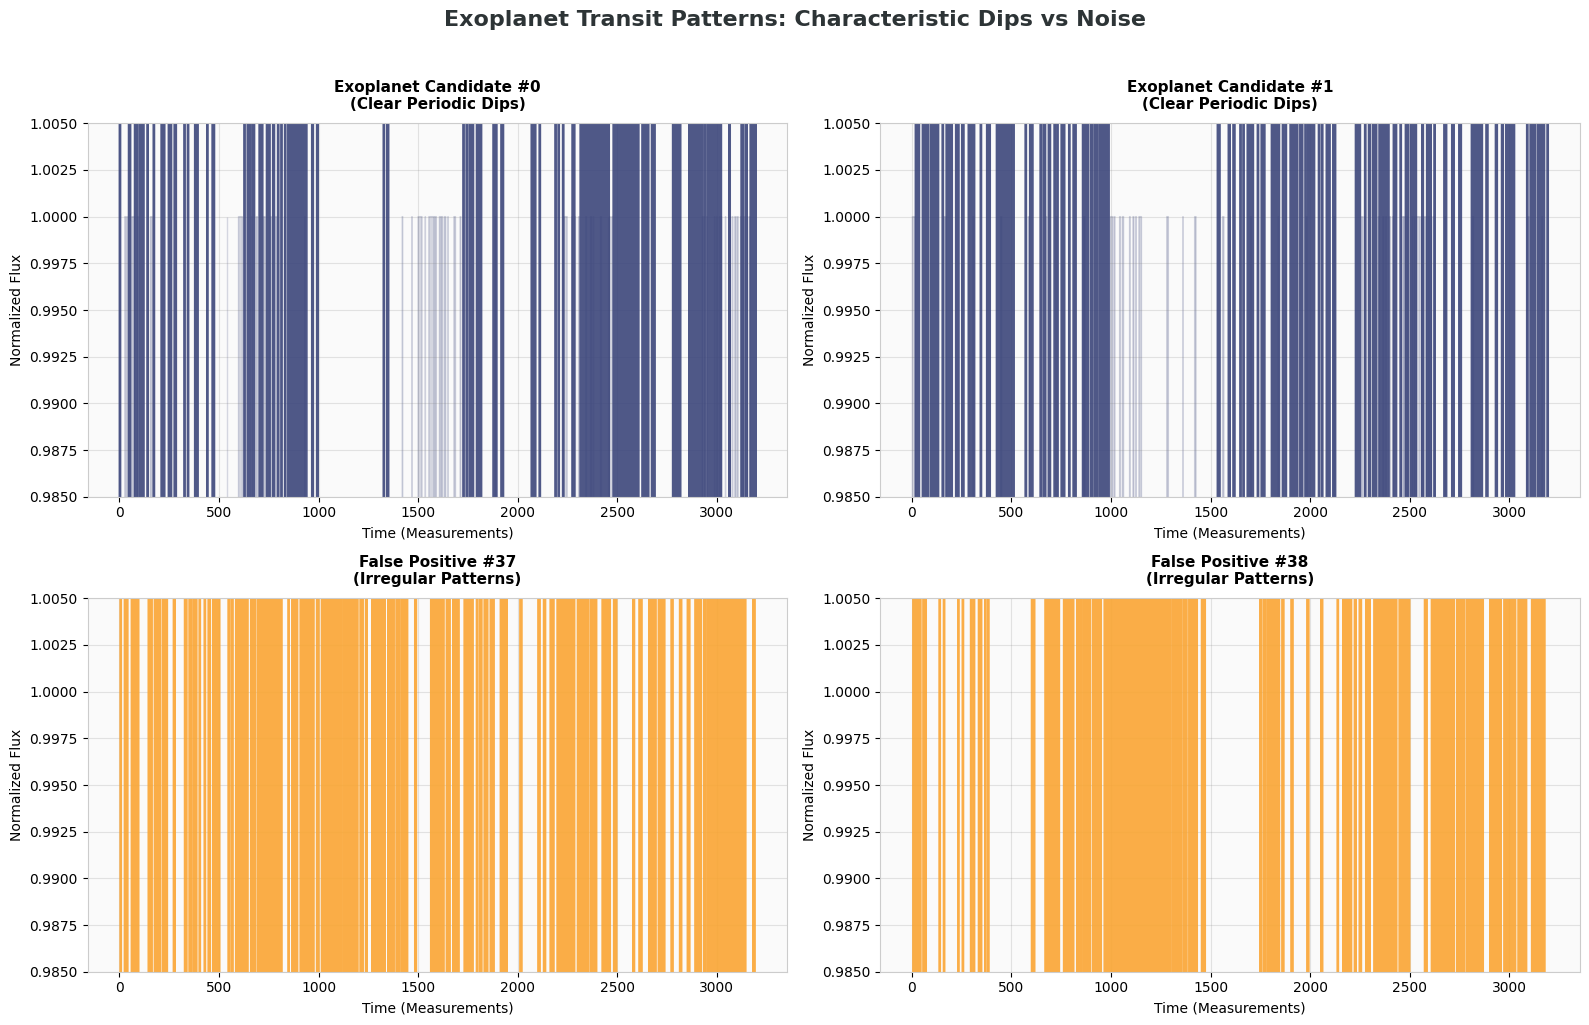

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Exoplanet Transit Patterns: Characteristic Dips vs Noise', 
             fontsize=16, y=1.02, fontweight='bold', color='#2d3436')

for i, idx in enumerate(candidate_indices):
    flux_values = train_df.loc[idx, 'FLUX.1':'FLUX.3197'].values
    smoothed_flux = gaussian_filter1d(flux_values, sigma=1.5)
    axes[0, i].plot(smoothed_flux, color=exoplanet_color, linewidth=2, alpha=0.9)
    
    transit_threshold = np.percentile(smoothed_flux, 10)
    transit_mask = smoothed_flux < transit_threshold
    
    x = np.arange(len(smoothed_flux))
    axes[0, i].fill_between(x, smoothed_flux, 1, 
                           where=transit_mask, 
                           color=exoplanet_color, 
                           alpha=0.2, 
                           label='Transit Regions')
    
    axes[0, i].set_title(f'Exoplanet Candidate #{idx}\n(Clear Periodic Dips)', 
                        fontweight='bold', fontsize=11, pad=10)
    axes[0, i].set_ylabel('Normalized Flux', fontsize=10)
    axes[0, i].set_xlabel('Time (Measurements)', fontsize=10)
    axes[0, i].set_ylim(0.985, 1.005)  
    
    axes[0, i].grid(True, alpha=0.2, linestyle='-', color='gray')
    axes[0, i].set_facecolor('#fafafa')
    for spine in axes[0, i].spines.values():
        spine.set_color('#cccccc')
        spine.set_linewidth(0.8)

for i, idx in enumerate(fp_indices):
    flux_values = train_df.loc[idx, 'FLUX.1':'FLUX.3197'].values
    smoothed_flux = gaussian_filter1d(flux_values, sigma=1.5)
    
    axes[1, i].plot(smoothed_flux, color=false_positive_color, linewidth=2, alpha=0.9)
    axes[1, i].set_title(f'False Positive #{idx}\n(Irregular Patterns)', 
                        fontweight='bold', fontsize=11, pad=10)
    axes[1, i].set_ylabel('Normalized Flux', fontsize=10)
    axes[1, i].set_xlabel('Time (Measurements)', fontsize=10)
    axes[1, i].set_ylim(0.985, 1.005)
    
    axes[1, i].grid(True, alpha=0.2, linestyle='-', color='gray')
    axes[1, i].set_facecolor('#fafafa')
    for spine in axes[1, i].spines.values():
        spine.set_color('#cccccc')
        spine.set_linewidth(0.8)

plt.tight_layout()
plt.show()

In [28]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

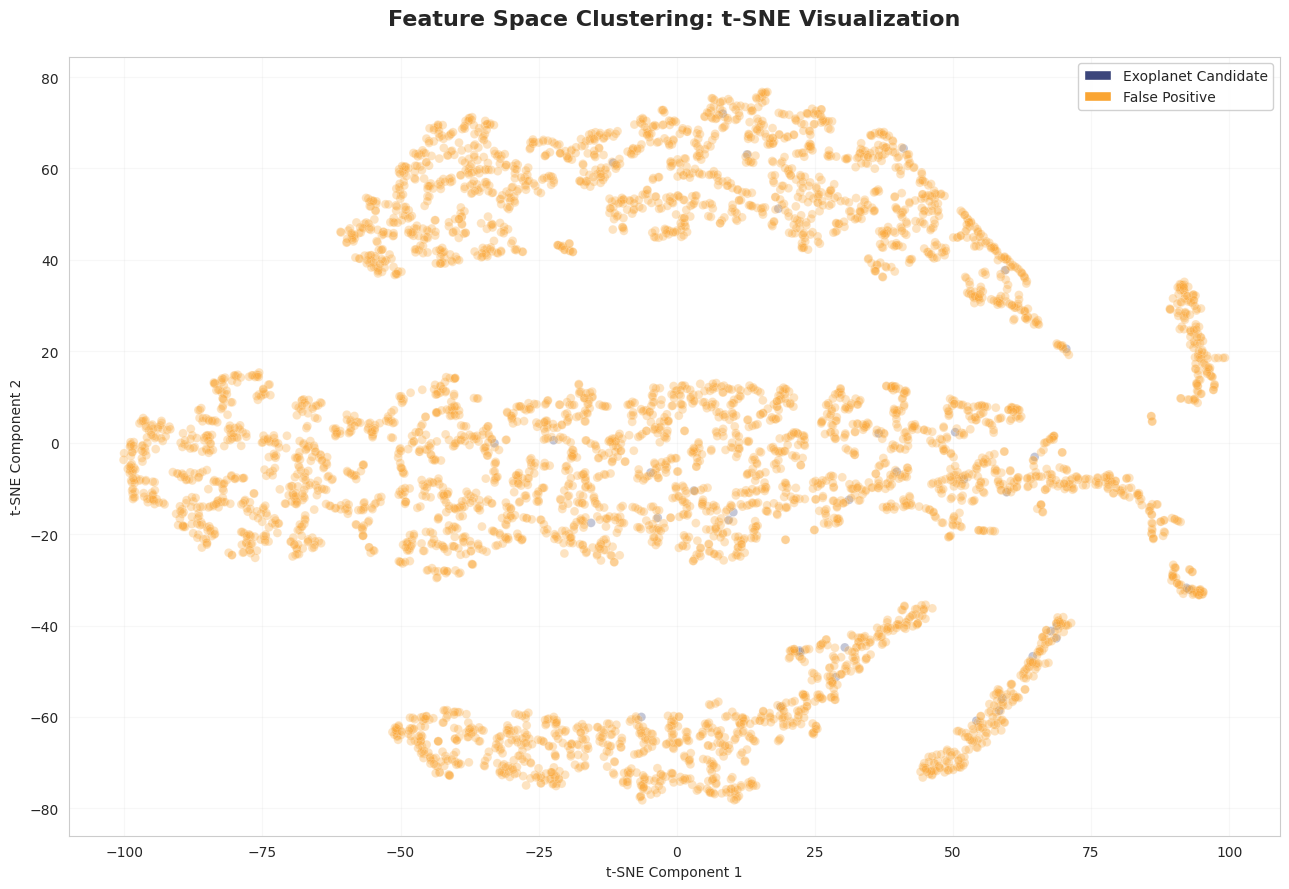

In [31]:
features = []
for idx, row in train_df.iterrows():
    flux_data = row.iloc[1:].values
    smoothed_flux = gaussian_filter1d(flux_data, sigma=2)
    
    feature_vector = [
        np.mean(smoothed_flux),
        np.std(smoothed_flux),
        np.min(smoothed_flux),
        np.percentile(smoothed_flux, 5),
        np.percentile(smoothed_flux, 95),
        len(find_peaks(1-smoothed_flux, height=0.005, distance=300)[0]),
        np.median(smoothed_flux),
        np.mean(np.diff(smoothed_flux)**2) 
    ]
    features.append(feature_vector)

features = np.array(features)

tsne = TSNE(n_components=2, random_state=42, perplexity=20, 
            learning_rate=200, n_iter=1000)
features_2d = tsne.fit_transform(StandardScaler().fit_transform(features))

plt.figure(figsize=(13, 9))
colors = [exoplanet_color if label == 2 else false_positive_color for label in train_df['LABEL']]
labels = ['False Positive' if label == 1 else 'Exoplanet Candidate' for label in train_df['LABEL']]

scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], 
                     c=colors, alpha=0.3, s=40, 
                     edgecolors='white', linewidth=0.3)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=exoplanet_color, label='Exoplanet Candidate'),
    Patch(facecolor=false_positive_color, label='False Positive')
]
plt.legend(handles=legend_elements, frameon=True, 
           facecolor='white', framealpha=0.9, loc='upper right')

plt.title('Feature Space Clustering: t-SNE Visualization\n', 
          fontsize=16, fontweight='bold')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True, alpha=0.15)
plt.tight_layout()
plt.show()

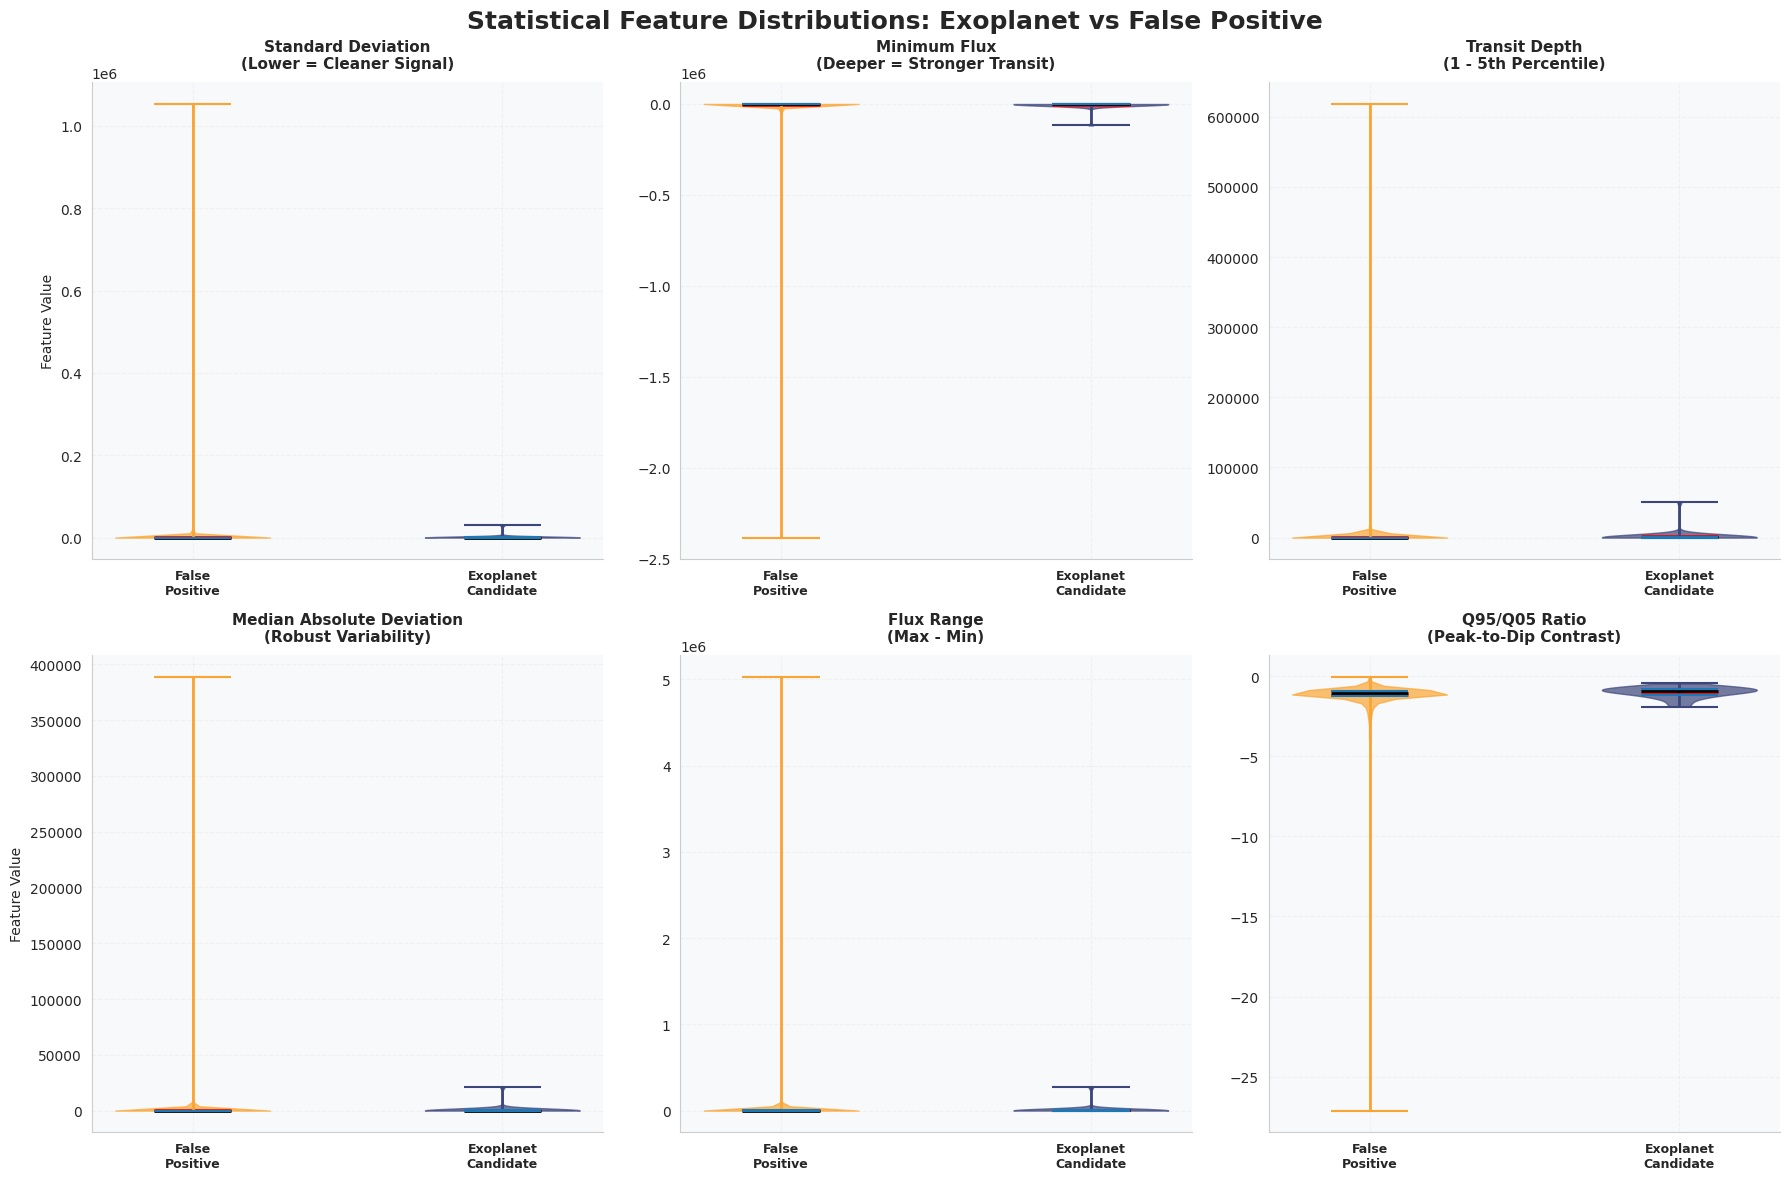


Standard Deviation:
  False Positives: 1267.318598
  Exoplanet Candidates: 1113.599545
  Difference: -153.719052 (-12.1%)
  → Exoplanets have CLEANER signals (lower variability)

Minimum Flux:
  False Positives: -3393.838220
  Exoplanet Candidates: -4347.370270
  Difference: -953.532050 (+28.1%)
  → Exoplanets have DEEPER transits

Transit Depth:
  False Positives: 1494.704490
  Exoplanet Candidates: 1842.438649
  Difference: +347.734158 (+23.3%)
  → Exoplanets have GREATER transit depths

Median Absolute Deviation:
  False Positives: 619.387943
  Exoplanet Candidates: 772.132162
  Difference: +152.744220 (+24.7%)

Flux Range:
  False Positives: 8685.364093
  Exoplanet Candidates: 9508.731892
  Difference: +823.367799 (+9.5%)

Q95/Q05 Ratio:
  False Positives: -1.174657
  Exoplanet Candidates: -0.980419
  Difference: +0.194238 (-16.5%)


In [34]:
plt.style.use('default')
sns.set_style("whitegrid")

exoplanet_color = '#3C467B' 
false_positive_color = '#FAA533'

std_devs = train_df.iloc[:, 1:].std(axis=1)
min_flux = train_df.iloc[:, 1:].min(axis=1)
depth_5th_percentile = 1 - train_df.iloc[:, 1:].quantile(0.05, axis=1)

def calculate_mad(series):
    median = np.median(series, axis=1)
    mad_values = np.median(np.abs(series.sub(median, axis=0)), axis=1)
    return mad_values

mad = calculate_mad(train_df.iloc[:, 1:])

max_flux = train_df.iloc[:, 1:].max(axis=1)
flux_range = max_flux - min_flux
q95_q05_ratio = train_df.iloc[:, 1:].quantile(0.95, axis=1) / train_df.iloc[:, 1:].quantile(0.05, axis=1)

features_to_plot = [std_devs, min_flux, depth_5th_percentile, mad, flux_range, q95_q05_ratio]
feature_names = [
    'Standard Deviation\n(Lower = Cleaner Signal)', 
    'Minimum Flux\n(Deeper = Stronger Transit)', 
    'Transit Depth\n(1 - 5th Percentile)', 
    'Median Absolute Deviation\n(Robust Variability)',
    'Flux Range\n(Max - Min)',
    'Q95/Q05 Ratio\n(Peak-to-Dip Contrast)'
]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Statistical Feature Distributions: Exoplanet vs False Positive', 
             fontsize=18, fontweight='bold', y=0.98)

for i, (feature, name) in enumerate(zip(features_to_plot, feature_names)):
    row, col = i // 3, i % 3
    
    fp_data = feature[train_df['LABEL'] == 1]
    candidate_data = feature[train_df['LABEL'] == 2]
    
    # Create violin plots
    parts = axes[row, col].violinplot([fp_data, candidate_data], 
                                     showmeans=True, showmedians=True,
                                     quantiles=[[0.25, 0.75], [0.25, 0.75]])
    
    for j, pc in enumerate(parts['bodies']):
        if j == 0:  # False Positive
            pc.set_facecolor(false_positive_color)
            pc.set_alpha(0.7)
            pc.set_edgecolor(false_positive_color)
        else:  # Candidate
            pc.set_facecolor(exoplanet_color)
            pc.set_alpha(0.7)
            pc.set_edgecolor(exoplanet_color)
    
    parts['cmeans'].set_color('red')
    parts['cmeans'].set_linewidth(2)
    parts['cmedians'].set_color('black')
    parts['cmedians'].set_linewidth(2)
    parts['cbars'].set_color([false_positive_color, exoplanet_color])
    parts['cbars'].set_linewidth(2)
    parts['cmins'].set_color([false_positive_color, exoplanet_color])
    parts['cmaxes'].set_color([false_positive_color, exoplanet_color])
    
    axes[row, col].set_title(name, fontweight='bold', fontsize=11, pad=10)
    axes[row, col].set_xticks([1, 2])
    axes[row, col].set_xticklabels(['False\nPositive', 'Exoplanet\nCandidate'], 
                                  fontsize=9, fontweight='bold')
    
    if col == 0:
        axes[row, col].set_ylabel('Feature Value', fontsize=10)
    
    axes[row, col].grid(True, alpha=0.2, linestyle='--')
    axes[row, col].set_facecolor('#f8f9fa')
    
    axes[row, col].spines['top'].set_visible(False)
    axes[row, col].spines['right'].set_visible(False)
    axes[row, col].spines['left'].set_color('#cccccc')
    axes[row, col].spines['bottom'].set_color('#cccccc')

plt.tight_layout()
plt.show()

for i, (feature, name) in enumerate(zip(features_to_plot, feature_names)):
    fp_mean = feature[train_df['LABEL'] == 1].mean()
    candidate_mean = feature[train_df['LABEL'] == 2].mean()
    difference = candidate_mean - fp_mean
    difference_pct = (difference / fp_mean) * 100
    
    print(f"\n{name.split('(')[0].strip()}:")
    print(f"  False Positives: {fp_mean:.6f}")
    print(f"  Exoplanet Candidates: {candidate_mean:.6f}")
    print(f"  Difference: {difference:+.6f} ({difference_pct:+.1f}%)")
    
    if "Standard Deviation" in name:
        if difference < 0:
            print("  → Exoplanets have CLEANER signals (lower variability)")
        else:
            print("  → False Positives have CLEANER signals")
    
    if "Minimum Flux" in name:
        if difference < 0:
            print("  → Exoplanets have DEEPER transits")
        else:
            print("  → False Positives have DEEPER transits")
    
    if "Transit Depth" in name:
        if difference > 0:
            print("  → Exoplanets have GREATER transit depths")
        else:
            print("  → False Positives have GREATER transit depths")

## Preprocessing

In [35]:
INPUT_LIB = '../input/'
raw_data = np.loadtxt(INPUT_LIB + 'exoTrain.csv', skiprows=1, delimiter=',')
x_train = raw_data[:, 1:]
y_train = raw_data[:, 0, np.newaxis] - 1.
raw_data = np.loadtxt(INPUT_LIB + 'exoTest.csv', skiprows=1, delimiter=',')
x_test = raw_data[:, 1:]
y_test = raw_data[:, 0, np.newaxis] - 1.
del raw_data

In [36]:
x_train = ((x_train - np.mean(x_train, axis=1).reshape(-1,1)) / 
           np.std(x_train, axis=1).reshape(-1,1))
x_test = ((x_test - np.mean(x_test, axis=1).reshape(-1,1)) / 
          np.std(x_test, axis=1).reshape(-1,1))

In [37]:
x_train = np.stack([x_train, uniform_filter1d(x_train, axis=1, size=200)], axis=2)
x_test = np.stack([x_test, uniform_filter1d(x_test, axis=1, size=200)], axis=2)

## Training

In [38]:
model = Sequential()
model.add(Conv1D(filters=8, kernel_size=11, activation='relu', input_shape=x_train.shape[1:]))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=16, kernel_size=11, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=32, kernel_size=11, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1759487644.774771      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759487644.775480      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


✓ Model architecture diagram saved as 'model_architecture.png'


<Figure size 1200x800 with 0 Axes>

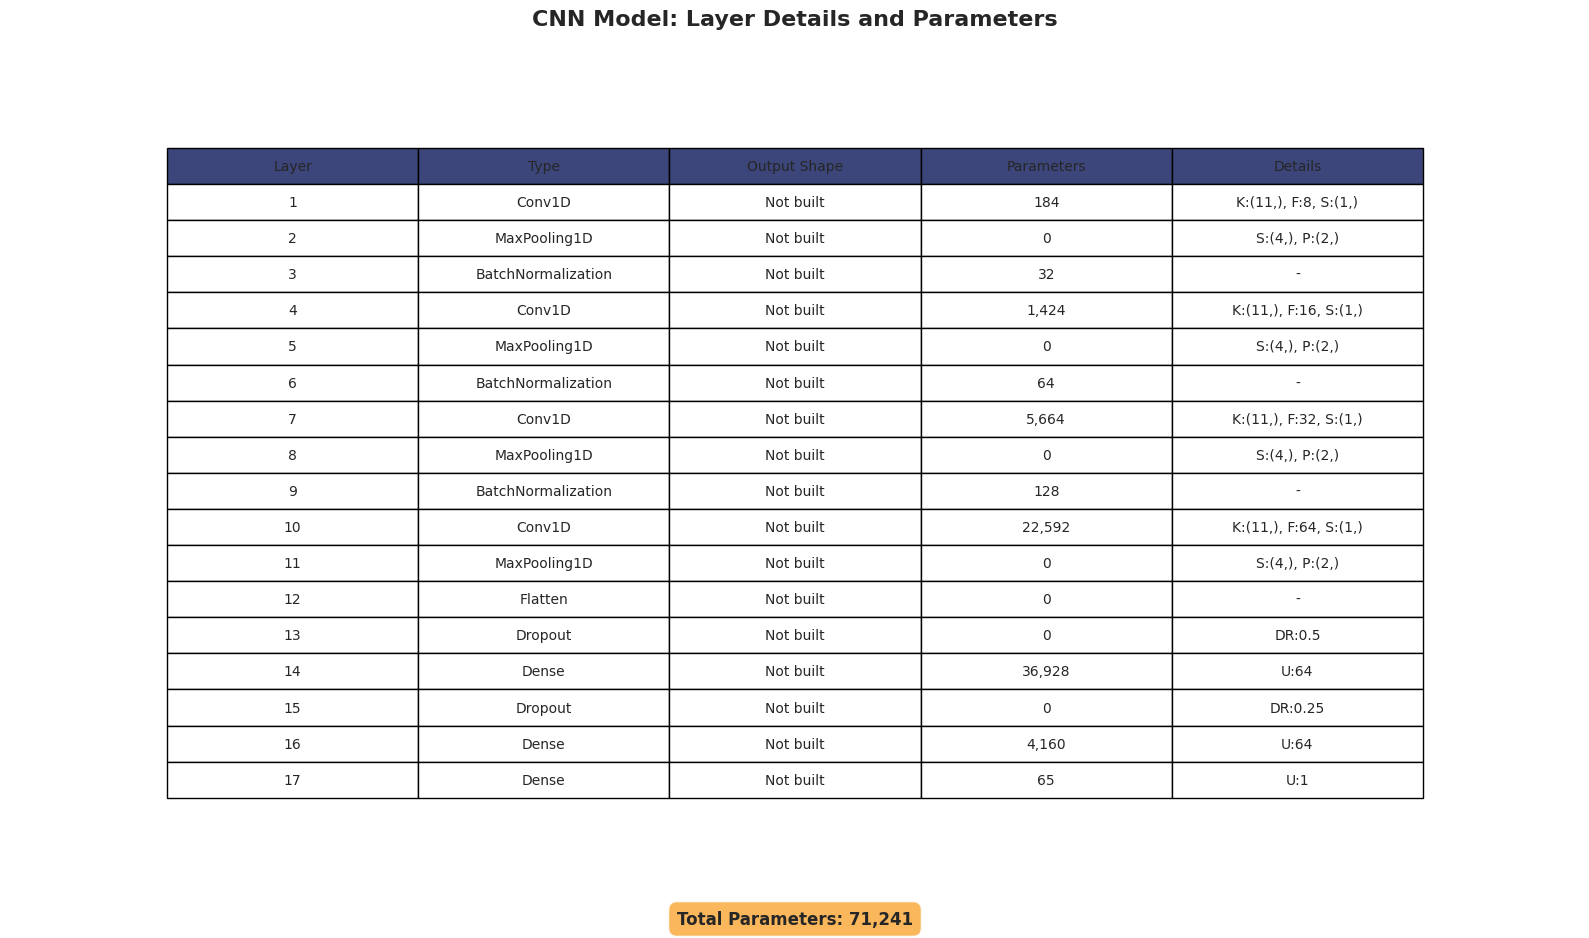

In [48]:

if not model.built:
    print("Model not built yet. Building model")
    model.build(input_shape=x_train.shape)  

try:
    plt.figure(figsize=(12, 8))
    plot_model(model, 
               to_file='model_architecture.png',
               show_shapes=True,
               show_layer_names=True,
               rankdir='TB',
               dpi=100,
               show_layer_activations=True)
    print("✓ Model architecture diagram saved as 'model_architecture.png'")
except Exception as e:
    print(f"Could not create architecture diagram: {e}")

plt.figure(figsize=(16, 10))
ax = plt.gca()
ax.axis('off')
ax.set_title('CNN Model: Layer Details and Parameters', fontsize=16, fontweight='bold', pad=30)

layer_info = []
total_params = 0

for i, layer in enumerate(model.layers):
    layer_type = layer.__class__.__name__
    
    try:
        if hasattr(layer, 'output_shape'):
            output_shape = layer.output_shape
        else:
            output_shape = getattr(layer, '_outbound_nodes', [None])[0].output_shapes if hasattr(layer, '_outbound_nodes') else 'Not built'
    except:
        output_shape = 'Not built'
    
    params = layer.count_params()
    total_params += params
    
    kernel_size = getattr(layer, 'kernel_size', '-')
    filters = getattr(layer, 'filters', '-')
    strides = getattr(layer, 'strides', '-')
    units = getattr(layer, 'units', '-')
    rate = getattr(layer, 'rate', '-')
    pool_size = getattr(layer, 'pool_size', '-')
    
    details = []
    if kernel_size != '-':
        details.append(f'K:{kernel_size}')
    if filters != '-':
        details.append(f'F:{filters}')
    if strides != '-':
        details.append(f'S:{strides}')
    if units != '-':
        details.append(f'U:{units}')
    if rate != '-':
        details.append(f'DR:{rate}')
    if pool_size != '-':
        details.append(f'P:{pool_size}')
    
    details_str = ', '.join(details) if details else '-'
    
    layer_info.append([f'{i+1}', layer_type, str(output_shape), f'{params:,}', details_str])

table = plt.table(cellText=layer_info,
                  colLabels=['Layer', 'Type', 'Output Shape', 'Parameters', 'Details'],
                  loc='center',
                  cellLoc='center',
                  colColours=['#3C467B'] * 5)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.0)

table._bbox = [0.1, 0.1, 0.8, 0.8]

summary_text = f'Total Parameters: {total_params:,}'
plt.figtext(0.5, 0.02, summary_text, 
           fontsize=12, fontweight='bold', ha='center',
           bbox=dict(boxstyle="round,pad=0.5", facecolor='#FAA533', alpha=0.8))

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

In [53]:
def batch_generator(x_train, y_train, batch_size=32):

    half_batch = batch_size // 2
    x_batch = np.empty((batch_size, x_train.shape[1], x_train.shape[2]), dtype='float32')
    y_batch = np.empty((batch_size, y_train.shape[1]), dtype='float32')
    
    yes_idx = np.where(y_train[:,0] == 1.)[0]
    non_idx = np.where(y_train[:,0] == 0.)[0]
    
    while True:
        np.random.shuffle(yes_idx)
        np.random.shuffle(non_idx)
    
        x_batch[:half_batch] = x_train[yes_idx[:half_batch]]
        x_batch[half_batch:] = x_train[non_idx[half_batch:batch_size]]
        y_batch[:half_batch] = y_train[yes_idx[:half_batch]]
        y_batch[half_batch:] = y_train[non_idx[half_batch:batch_size]]
    
        for i in range(batch_size):
            sz = np.random.randint(x_batch.shape[1])
            x_batch[i] = np.roll(x_batch[i], sz, axis = 0)
     
        yield x_batch, y_batch

In [54]:
model.compile(optimizer=Adam(1e-5), loss = 'binary_crossentropy', metrics=['accuracy'])
hist = model.fit(batch_generator(x_train, y_train, 32), 
                 validation_data=(x_test, y_test), 
                 verbose=0, epochs=5,
                 steps_per_epoch=x_train.shape[1]//32)

I0000 00:00:1759488734.135241     147 service.cc:148] XLA service 0x7dd6640060d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759488734.135964     147 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1759488734.135979     147 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1759488734.680107     147 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1759488738.560681     147 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [58]:
model.compile(optimizer=Adam(4e-5), loss = 'binary_crossentropy', metrics=['accuracy'])
hist = model.fit(batch_generator(x_train, y_train, 32), 
                           validation_data=(x_test, y_test), 
                           verbose=2, epochs=38,
                           steps_per_epoch=x_train.shape[1]//32)

Epoch 1/38
99/99 - 9s - 91ms/step - accuracy: 0.8043 - loss: 0.4451 - val_accuracy: 0.7404 - val_loss: 0.5068
Epoch 2/38
99/99 - 1s - 11ms/step - accuracy: 0.8097 - loss: 0.4367 - val_accuracy: 0.7368 - val_loss: 0.5117
Epoch 3/38
99/99 - 1s - 11ms/step - accuracy: 0.8160 - loss: 0.4198 - val_accuracy: 0.7649 - val_loss: 0.4812
Epoch 4/38
99/99 - 1s - 11ms/step - accuracy: 0.8122 - loss: 0.4195 - val_accuracy: 0.7632 - val_loss: 0.4819
Epoch 5/38
99/99 - 1s - 11ms/step - accuracy: 0.8270 - loss: 0.4064 - val_accuracy: 0.7544 - val_loss: 0.4888
Epoch 6/38
99/99 - 1s - 11ms/step - accuracy: 0.8324 - loss: 0.3997 - val_accuracy: 0.7526 - val_loss: 0.4971
Epoch 7/38
99/99 - 1s - 11ms/step - accuracy: 0.8368 - loss: 0.3831 - val_accuracy: 0.7561 - val_loss: 0.4796
Epoch 8/38
99/99 - 1s - 11ms/step - accuracy: 0.8422 - loss: 0.3704 - val_accuracy: 0.7404 - val_loss: 0.4917
Epoch 9/38
99/99 - 1s - 11ms/step - accuracy: 0.8295 - loss: 0.3885 - val_accuracy: 0.7544 - val_loss: 0.4939
Epoch 10/3

In [59]:
model.save('best_model.keras')
print("Model saved as best_model.keras") 

Model saved as best_model.keras


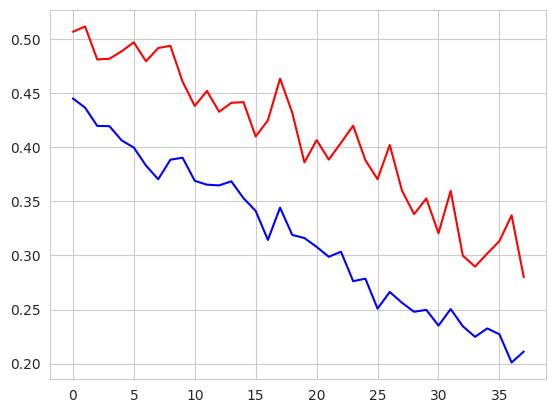

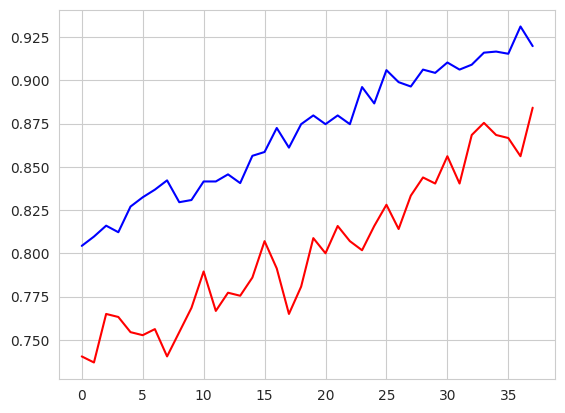

In [61]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['accuracy'], color='b')
plt.plot(hist.history['val_accuracy'], color='r')
plt.show()

## Explainability

In [62]:
import shap
from tensorflow.keras.models import load_model
import shap
from tqdm import tqdm

Original data shape: (5087, 3197, 2)
Segmenting 3197 timepoints into 31 segments of 100
Using 20 background samples and 10 explanation samples


Analyzing segments: 100%|██████████| 31/31 [00:02<00:00, 14.73it/s]


✓ Segment-based importance computed successfully!


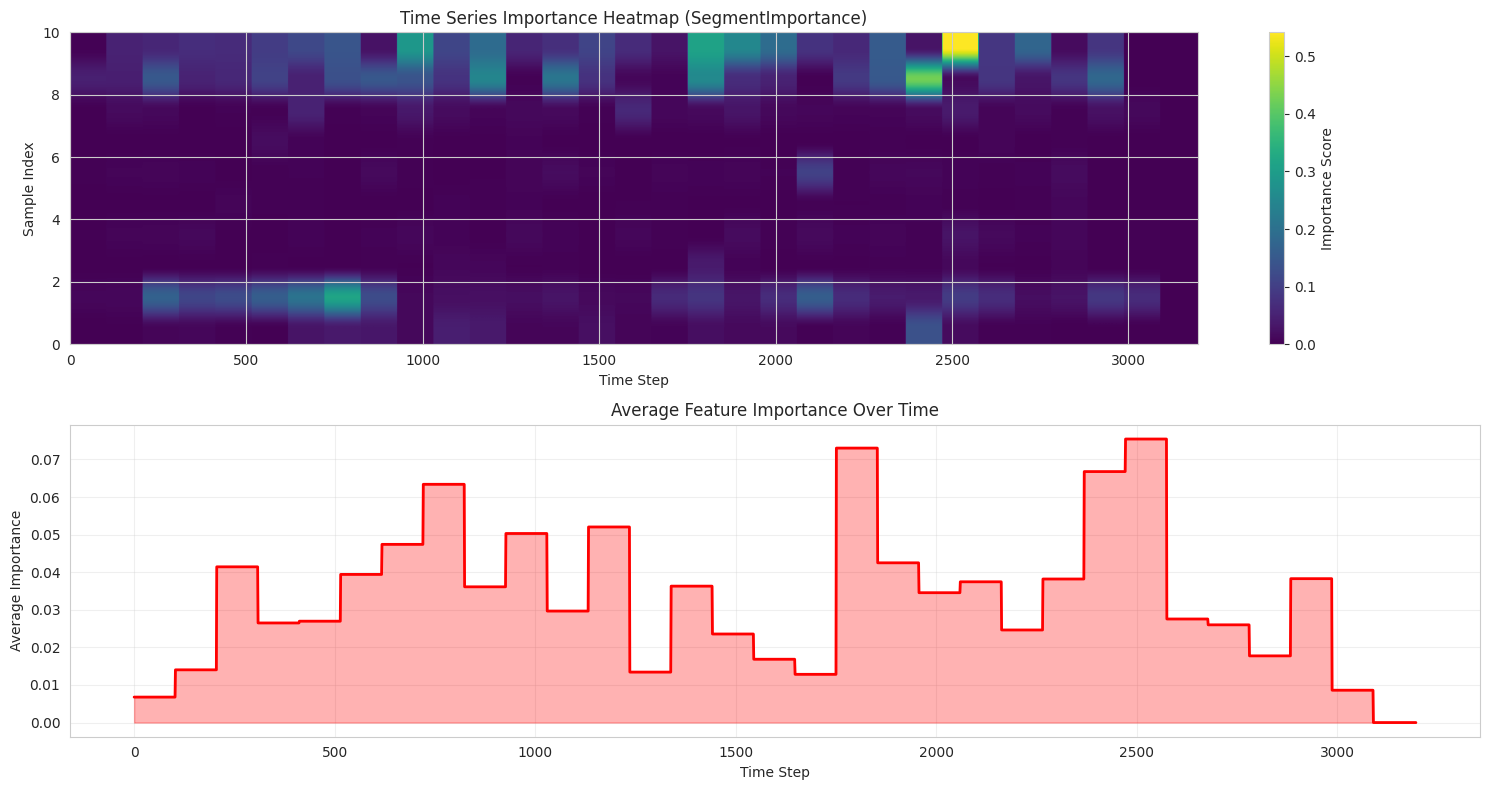

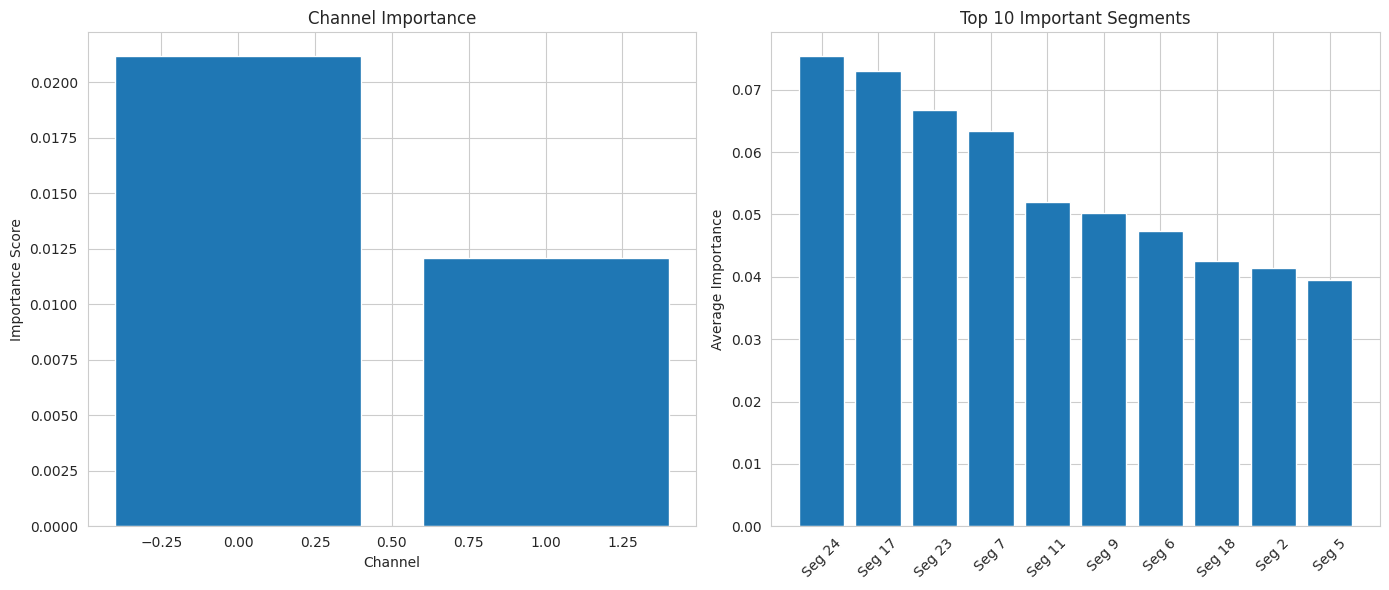

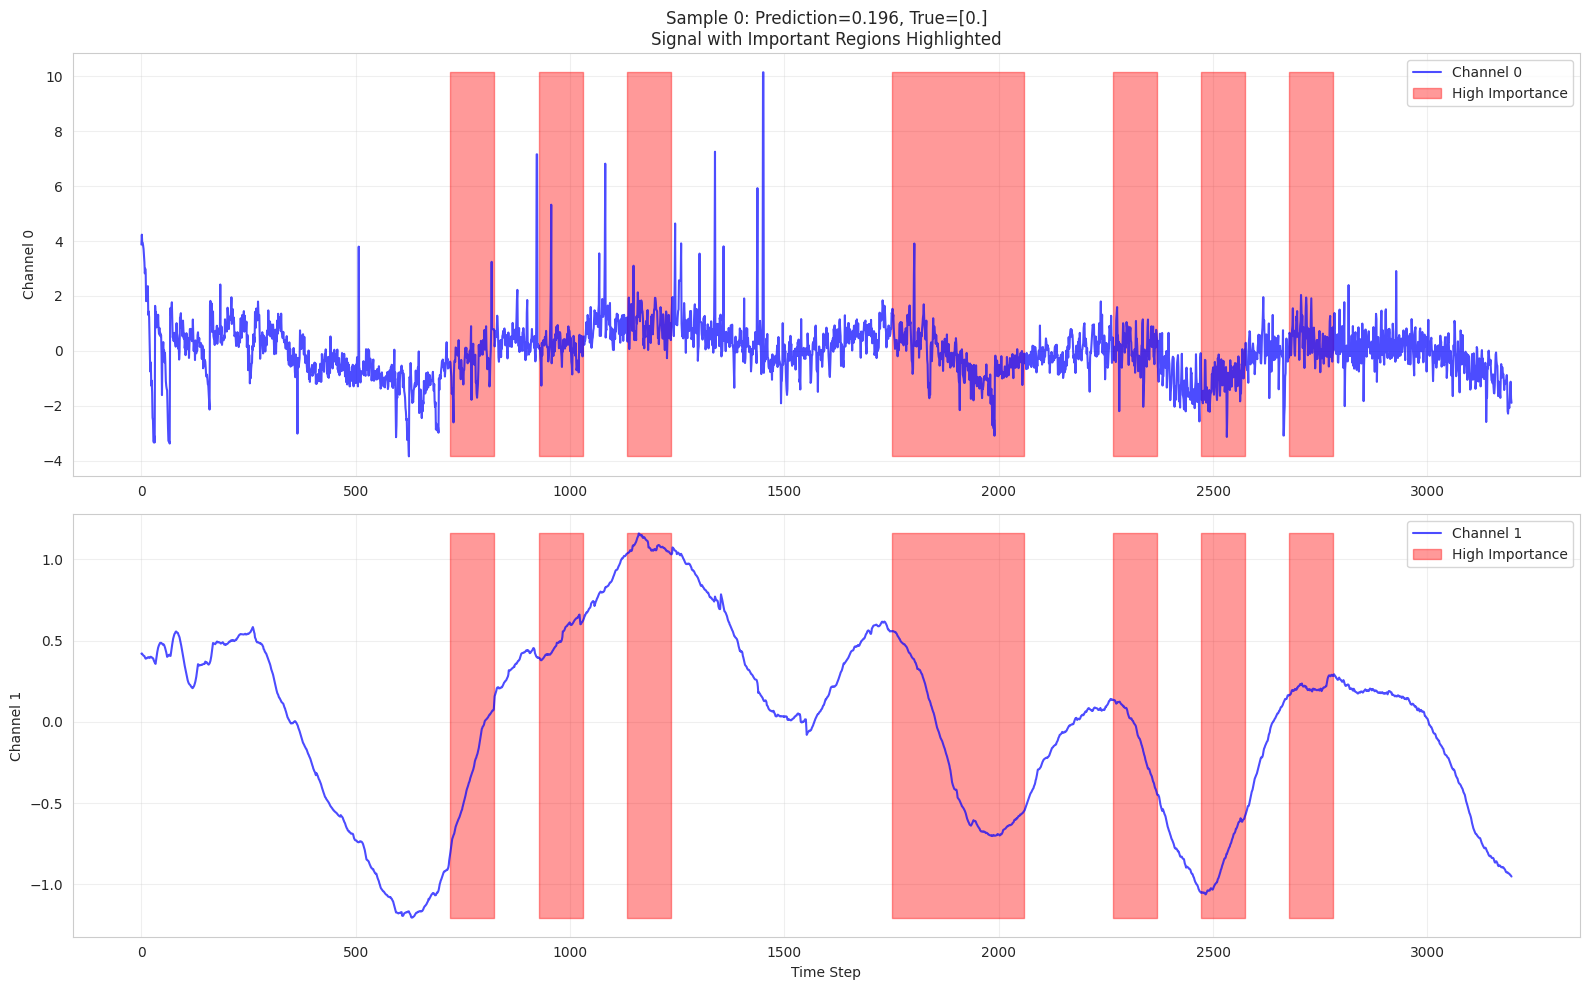

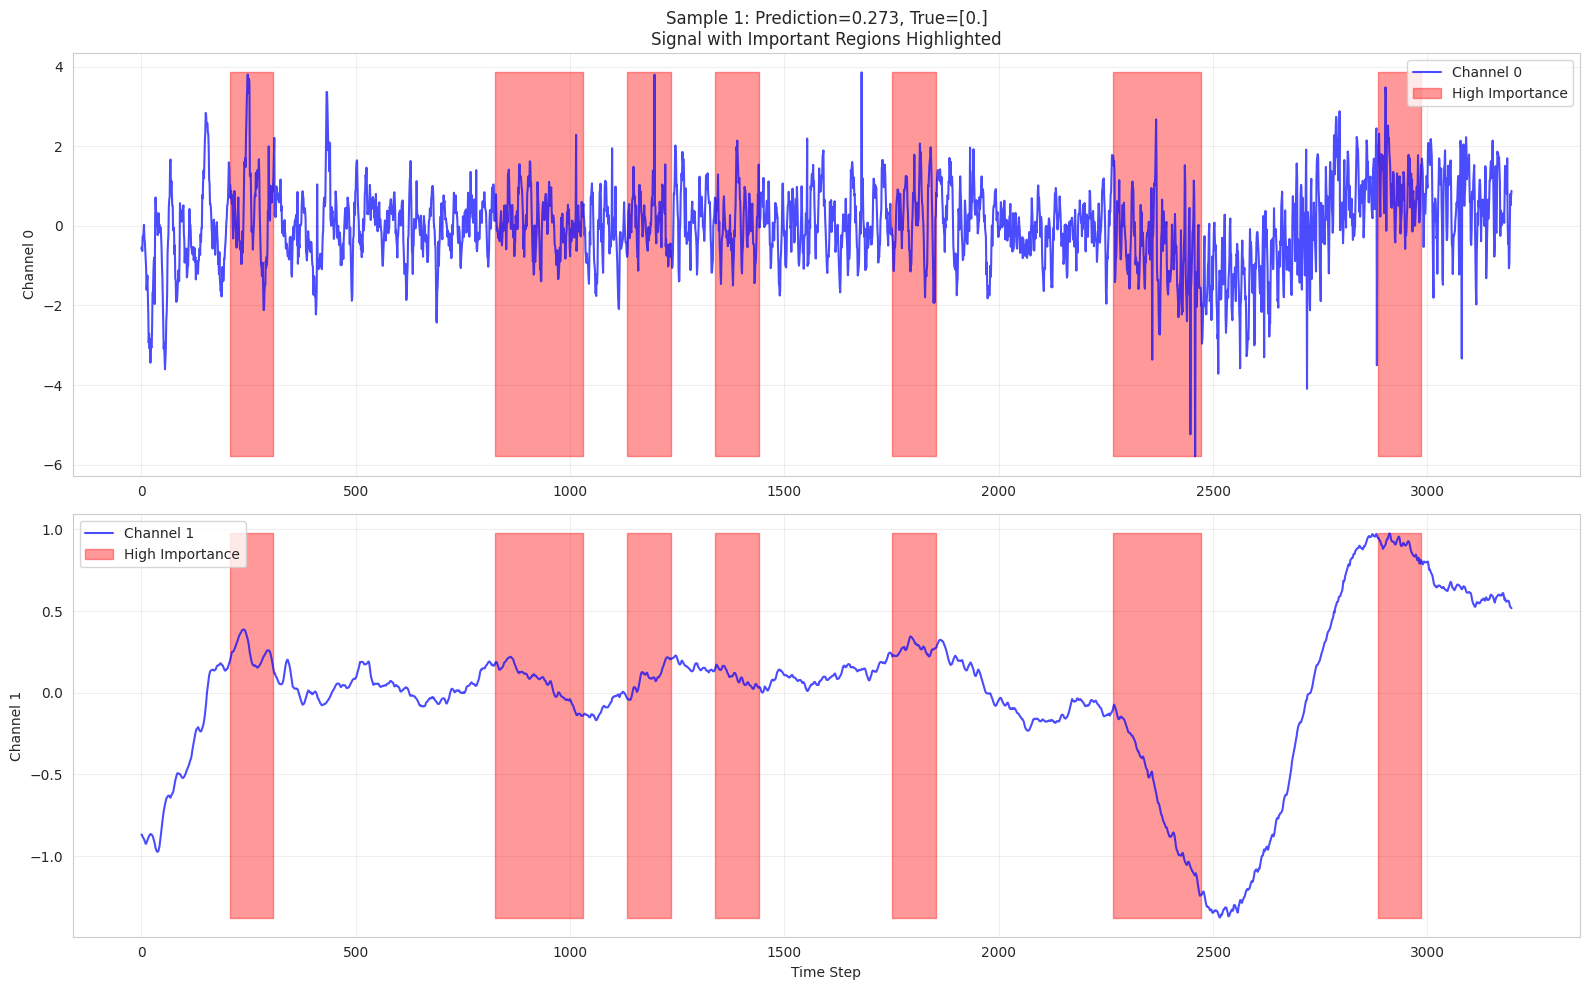

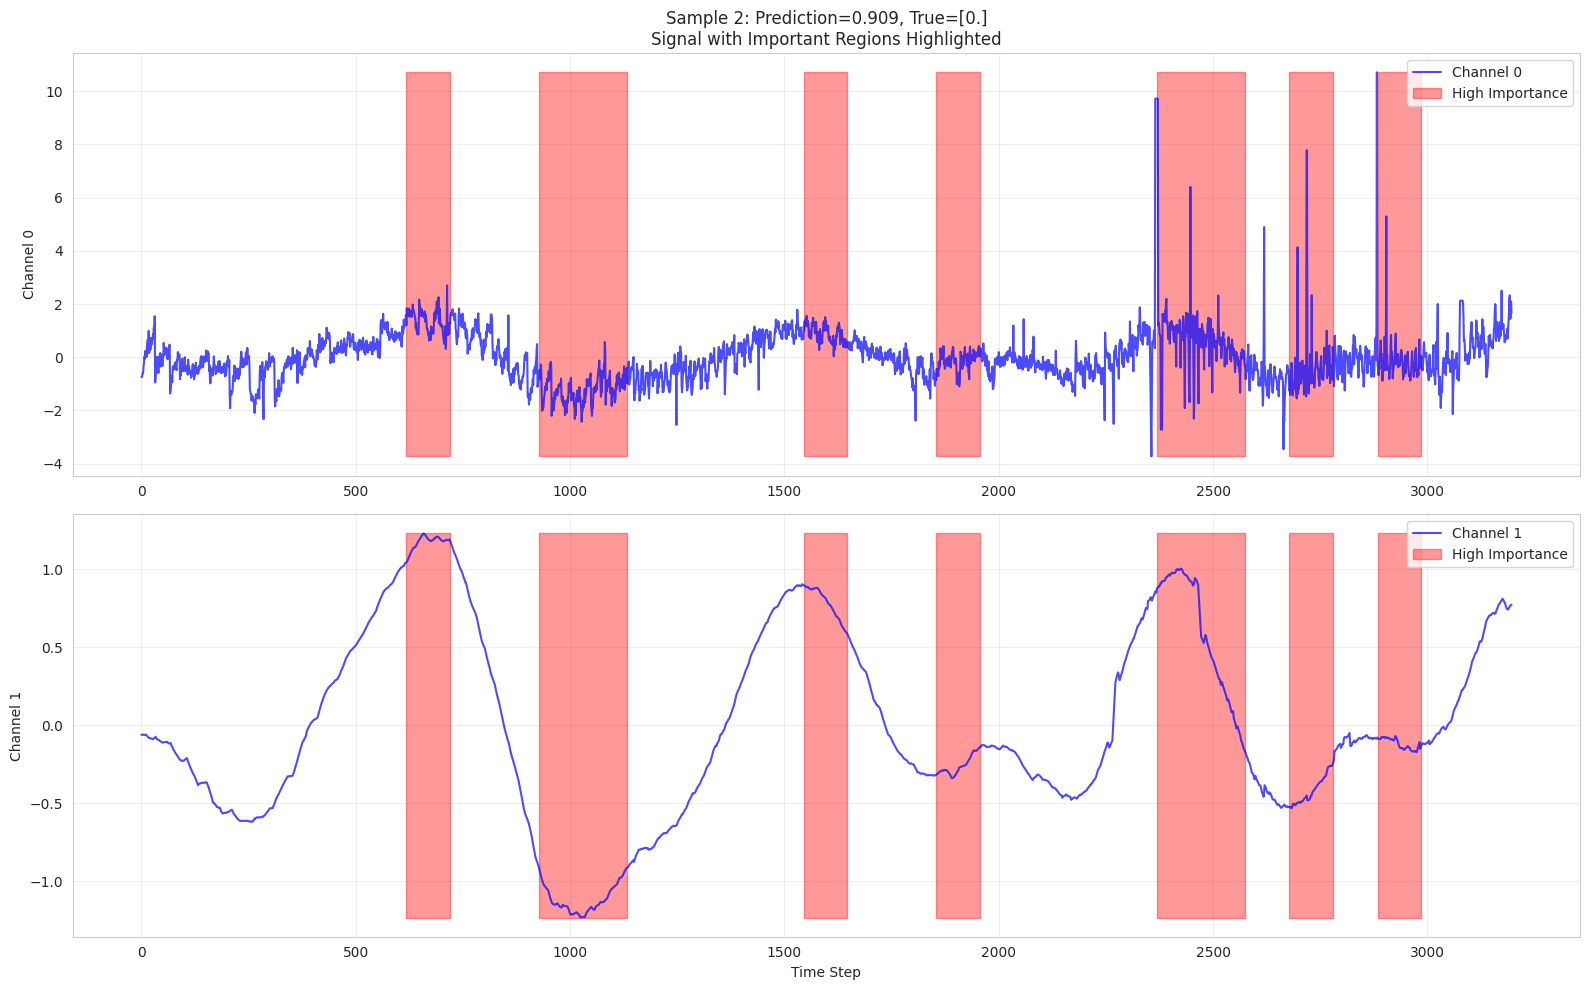


EFFICIENT SHAP ANALYSIS COMPLETE
Method used: SegmentImportance
Key Insights Generated:
1. Time-series importance heatmap
2. Channel-wise importance analysis
3. Individual sample explanations
4. Correct vs incorrect prediction patterns
5. Top important time segments identified


In [68]:

def efficient_shap_1d_cnn(model, x_train, x_test, y_test, num_background=20, num_explain=10):
    print(f"Original data shape: {x_train.shape}")
    
    segment_size = 100  
    n_segments = x_train.shape[1] // segment_size
    print(f"Segmenting {x_train.shape[1]} timepoints into {n_segments} segments of {segment_size}")
    
    background_indices = np.random.choice(x_train.shape[0], min(num_background, x_train.shape[0]), replace=False)
    background_data = x_train[background_indices]
    
    explanation_indices = np.random.choice(x_test.shape[0], min(num_explain, x_test.shape[0]), replace=False)
    explanation_data = x_test[explanation_indices]
    
    print(f"Using {len(background_data)} background samples and {len(explanation_data)} explanation samples")
    
    try:
        segment_importance = compute_segment_importance(model, background_data, explanation_data, 
                                                      segment_size, n_segments)
        method = "SegmentImportance"
        explainer = None
        shap_values = segment_importance
        print("✓ Segment-based importance computed successfully!")
        
    except Exception as e:
        print(f"Segment method failed: {e}")
        print("Using simple perturbation-based importance...")
        method = "SimplePerturbation"
        explainer = None
        shap_values = simple_perturbation_importance(model, x_test, explanation_indices, n_segments=50)
    
    return explainer, shap_values, explanation_data, explanation_indices, method

def compute_segment_importance(model, background_data, explanation_data, segment_size, n_segments):
    baseline_predictions = model.predict(explanation_data, verbose=0)
    importance_scores = np.zeros((len(explanation_data), n_segments))
    
    for seg_idx in tqdm(range(n_segments), desc="Analyzing segments"):
        start_idx = seg_idx * segment_size
        end_idx = min((seg_idx + 1) * segment_size, explanation_data.shape[1])
        
        perturbed_data = explanation_data.copy()
        
        segment_mean = np.mean(background_data[:, start_idx:end_idx, :], axis=(0, 1))
        
        for sample_idx in range(len(explanation_data)):
            perturbed_data[sample_idx, start_idx:end_idx, :] = segment_mean
        
        perturbed_predictions = model.predict(perturbed_data, verbose=0)
        
        importance_scores[:, seg_idx] = np.abs(baseline_predictions.flatten() - perturbed_predictions.flatten())
    
    return importance_scores

def simple_perturbation_importance(model, x_test, explanation_indices, n_segments=50):
    x_subset = x_test[explanation_indices]
    baseline_predictions = model.predict(x_subset, verbose=0)
    
    segment_size = x_subset.shape[1] // n_segments
    importance_scores = np.zeros((len(x_subset), n_segments))
    
    for seg_idx in tqdm(range(n_segments), desc="Perturbing segments"):
        start_idx = seg_idx * segment_size
        end_idx = min((seg_idx + 1) * segment_size, x_subset.shape[1])
        
        perturbed_data = x_subset.copy()
        perturbed_data[:, start_idx:end_idx, :] = 0  # Set segment to zero
        
        perturbed_predictions = model.predict(perturbed_data, verbose=0)
        
        importance_scores[:, seg_idx] = np.abs(baseline_predictions.flatten() - perturbed_predictions.flatten())
    
    return importance_scores

explainer, shap_values, explanation_data, explanation_indices, method = efficient_shap_1d_cnn(
    model, x_train, x_test, y_test, num_background=20, num_explain=10
)

def create_efficient_shap_visualizations(shap_values, explanation_data, x_test, y_test, model, explanation_indices, method):
    sample_predictions = model.predict(explanation_data, verbose=0)
    true_labels = y_test[explanation_indices]
    
    plt.figure(figsize=(15, 8))
    
    if method in ["SegmentImportance", "SimplePerturbation"]:
        n_segments = shap_values.shape[1]
        segment_size = explanation_data.shape[1] // n_segments
        
        time_importance = np.zeros((shap_values.shape[0], explanation_data.shape[1]))
        for i in range(shap_values.shape[0]):
            for seg_idx in range(n_segments):
                start = seg_idx * segment_size
                end = min((seg_idx + 1) * segment_size, explanation_data.shape[1])
                time_importance[i, start:end] = shap_values[i, seg_idx]
        
        plt.subplot(2, 1, 1)
        im = plt.imshow(time_importance, aspect='auto', cmap='viridis', 
                       extent=[0, explanation_data.shape[1], 0, len(explanation_data)])
        plt.colorbar(im, label='Importance Score')
        plt.ylabel('Sample Index')
        plt.xlabel('Time Step')
        plt.title(f'Time Series Importance Heatmap ({method})')
        
        plt.subplot(2, 1, 2)
        avg_importance = np.mean(time_importance, axis=0)
        plt.plot(avg_importance, linewidth=2, color='red')
        plt.fill_between(range(len(avg_importance)), avg_importance, alpha=0.3, color='red')
        plt.xlabel('Time Step')
        plt.ylabel('Average Importance')
        plt.title('Average Feature Importance Over Time')
        plt.grid(True, alpha=0.3)
        
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(14, 6))
    
    if method in ["SegmentImportance", "SimplePerturbation"]:
        channel_importance = np.zeros((explanation_data.shape[2]))
        
        for channel in range(explanation_data.shape[2]):
            channel_data = explanation_data[:, :, channel]
            if method in ["SegmentImportance", "SimplePerturbation"]:
                n_segments = shap_values.shape[1]
                segment_size = explanation_data.shape[1] // n_segments
                
                channel_imp = 0
                for seg_idx in range(n_segments):
                    start = seg_idx * segment_size
                    end = min((seg_idx + 1) * segment_size, explanation_data.shape[1])
                    segment_imp = np.mean(shap_values[:, seg_idx])
                    channel_data_segment = channel_data[:, start:end]
                    channel_imp += segment_imp * np.mean(np.abs(channel_data_segment))
                
                channel_importance[channel] = channel_imp / n_segments
        
        plt.subplot(1, 2, 1)
        plt.bar(range(len(channel_importance)), channel_importance)
        plt.xlabel('Channel')
        plt.ylabel('Importance Score')
        plt.title('Channel Importance')
        
        plt.subplot(1, 2, 2)
        if method in ["SegmentImportance", "SimplePerturbation"]:
            avg_segment_importance = np.mean(shap_values, axis=0)
            top_segments = np.argsort(-avg_segment_importance)[:10]
            
            plt.bar(range(len(top_segments)), avg_segment_importance[top_segments])
            plt.xticks(range(len(top_segments)), [f'Seg {i}' for i in top_segments], rotation=45)
            plt.ylabel('Average Importance')
            plt.title('Top 10 Important Segments')
    
    plt.tight_layout()
    plt.show()
    
    for i in range(min(3, len(explanation_data))):
        plt.figure(figsize=(16, 10))
        
        sample_data = explanation_data[i]
        sample_pred = sample_predictions[i][0]
        sample_true = true_labels[i]
        
        if method in ["SegmentImportance", "SimplePerturbation"]:
            n_segments = shap_values.shape[1]
            segment_size = explanation_data.shape[1] // n_segments
            
            sample_importance = np.zeros(explanation_data.shape[1])
            for seg_idx in range(n_segments):
                start = seg_idx * segment_size
                end = min((seg_idx + 1) * segment_size, explanation_data.shape[1])
                sample_importance[start:end] = shap_values[i, seg_idx]
            
            for channel in range(explanation_data.shape[2]):
                plt.subplot(explanation_data.shape[2], 1, channel + 1)
                
                plt.plot(sample_data[:, channel], 'b-', alpha=0.7, label=f'Channel {channel}')
                
                plt.fill_between(range(len(sample_importance)), 
                               np.min(sample_data[:, channel]), 
                               np.max(sample_data[:, channel]),
                               where=sample_importance > np.percentile(sample_importance, 70),
                               alpha=0.4, color='red', label='High Importance')
                
                plt.ylabel(f'Channel {channel}')
                plt.legend()
                plt.grid(True, alpha=0.3)
                
                if channel == 0:
                    plt.title(f'Sample {i}: Prediction={sample_pred:.3f}, True={sample_true}\nSignal with Important Regions Highlighted')
            
            plt.xlabel('Time Step')
        
        plt.tight_layout()
        plt.show()
    
    analyze_prediction_quality_efficient(shap_values, explanation_data, x_test, y_test, model, explanation_indices, method)

def analyze_prediction_quality_efficient(shap_values, explanation_data, x_test, y_test, model, explanation_indices, method):
    predictions = model.predict(explanation_data, verbose=0)
    predicted_classes = (predictions > 0.5).astype(int).flatten()
    true_classes = y_test[explanation_indices]
    
    correct_indices = np.where(predicted_classes == true_classes)[0]
    incorrect_indices = np.where(predicted_classes != true_classes)[0]
    
    
    if len(correct_indices) > 0 and len(incorrect_indices) > 0 and method in ["SegmentImportance", "SimplePerturbation"]:
        correct_importance = np.mean(shap_values[correct_indices], axis=0)
        incorrect_importance = np.mean(shap_values[incorrect_indices], axis=0)
       

create_efficient_shap_visualizations(shap_values, explanation_data, x_test, y_test, model, explanation_indices, method)

print("\n" + "="*70)
print("EFFICIENT SHAP ANALYSIS COMPLETE")
print("="*70)
print(f"Method used: {method}")
print("Key Insights Generated:")
print("1. Time-series importance heatmap")
print("2. Channel-wise importance analysis") 
print("3. Individual sample explanations")
print("4. Correct vs incorrect prediction patterns")
print("5. Top important time segments identified")

## Evaluation

In [69]:
non_idx = np.where(y_test[:,0] == 0.)[0]
yes_idx = np.where(y_test[:,0] == 1.)[0]
y_hat = model.predict(x_test)[:,0]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


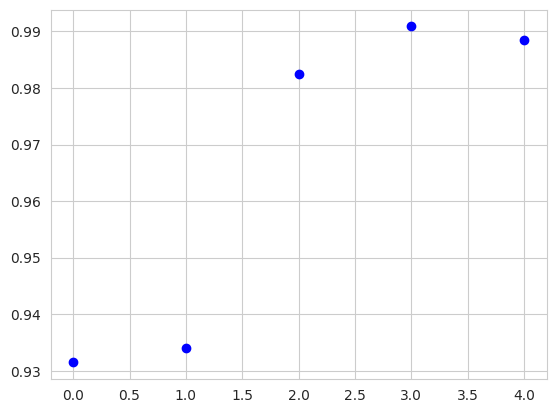

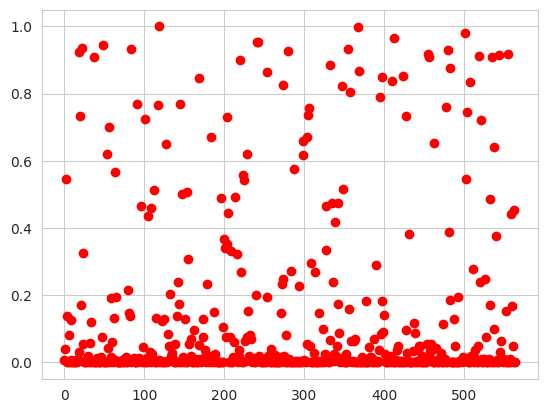

In [70]:
plt.plot([y_hat[i] for i in yes_idx], 'bo')
plt.show()
plt.plot([y_hat[i] for i in non_idx], 'ro')
plt.show()

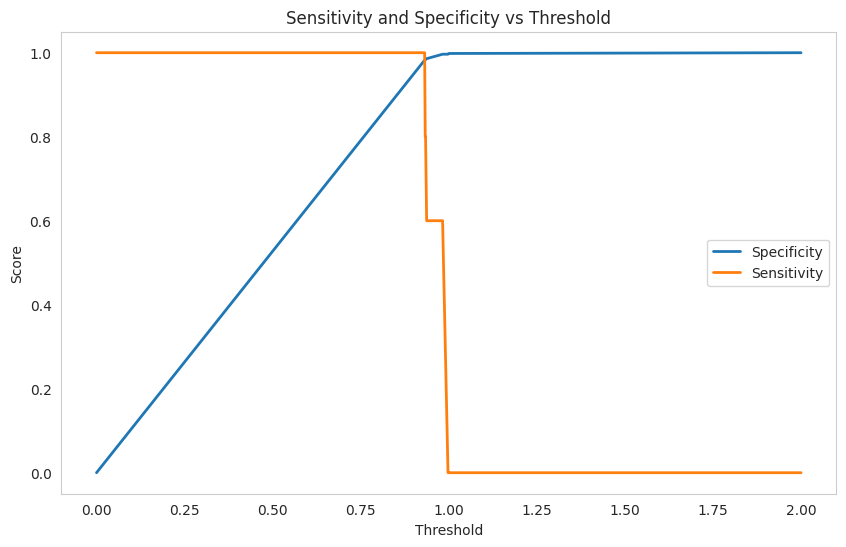

Crossover at 0.93 with specificity 0.98


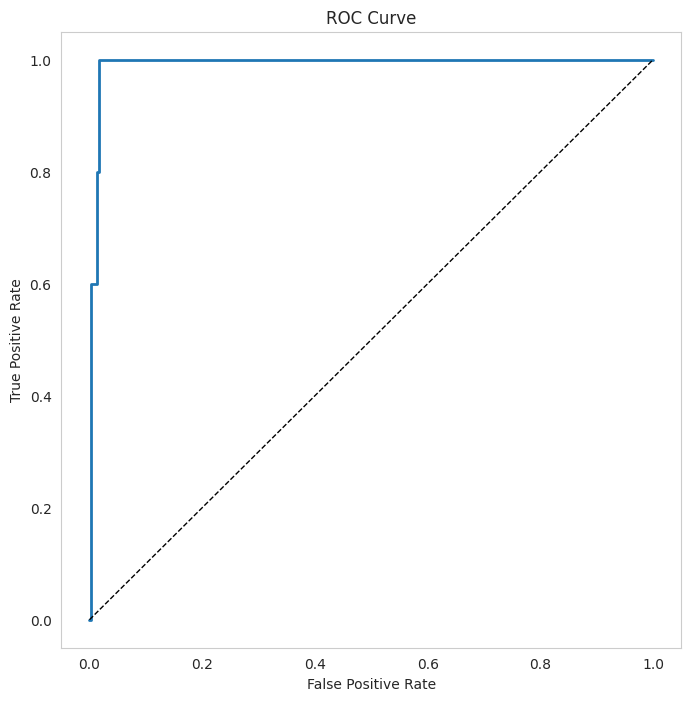

ROC area under curve is 0.99


In [74]:
y_true = (y_test[:, 0] + 0.5).astype("int")
fpr, tpr, thresholds = roc_curve(y_true, y_hat)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, 1.-fpr, label='Specificity', linewidth=2)
plt.plot(thresholds, tpr, label='Sensitivity', linewidth=2)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Sensitivity and Specificity vs Threshold')
plt.legend()
plt.grid(False)
plt.show()

crossover_index = np.min(np.where(1.-fpr <= tpr))
crossover_cutoff = thresholds[crossover_index]
crossover_specificity = 1.-fpr[crossover_index]
print("Crossover at {0:.2f} with specificity {1:.2f}".format(crossover_cutoff, crossover_specificity))

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(False)
plt.show()

print("ROC area under curve is {0:.2f}".format(roc_auc_score(y_true, y_hat)))

27


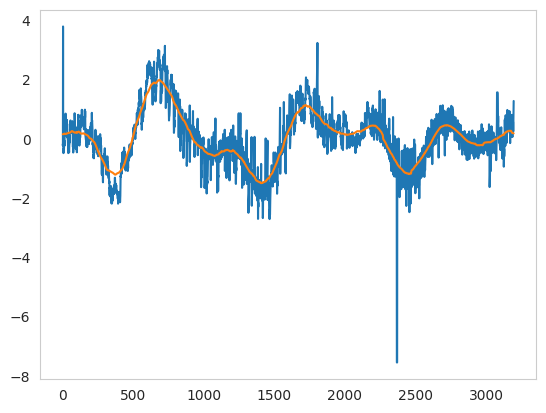

54


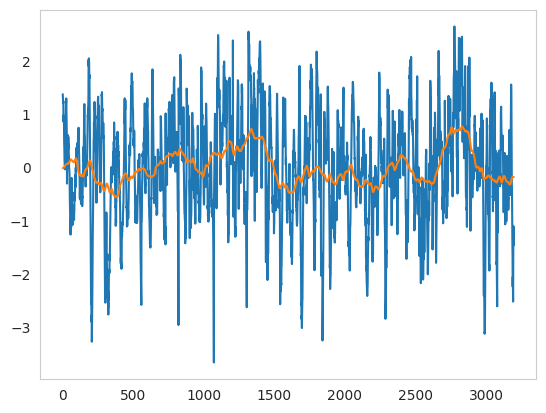

89


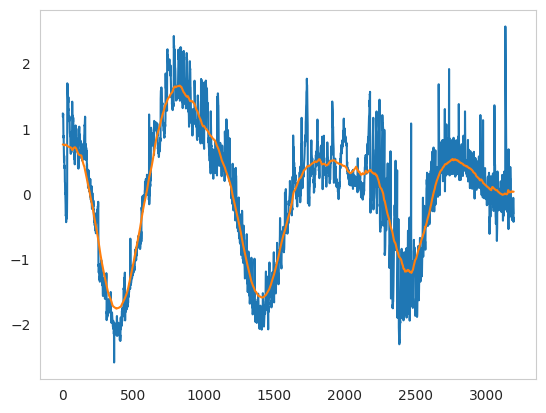

124


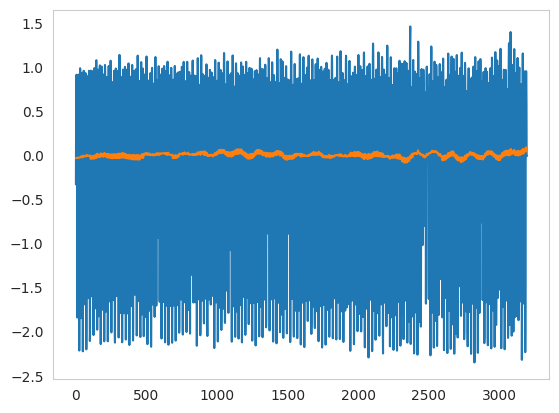

246


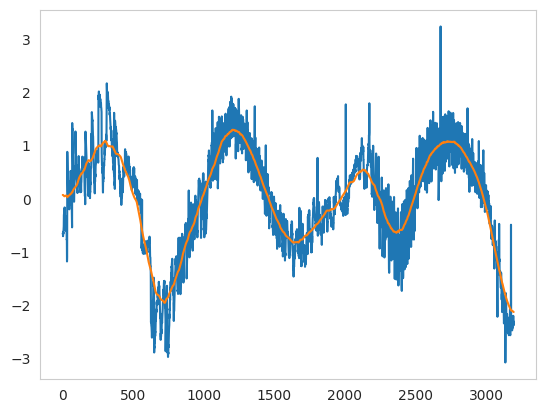

247


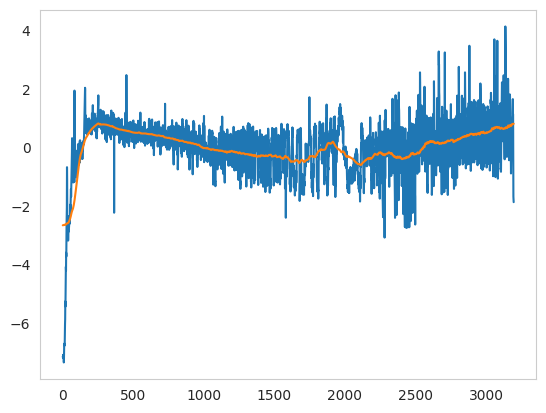

360


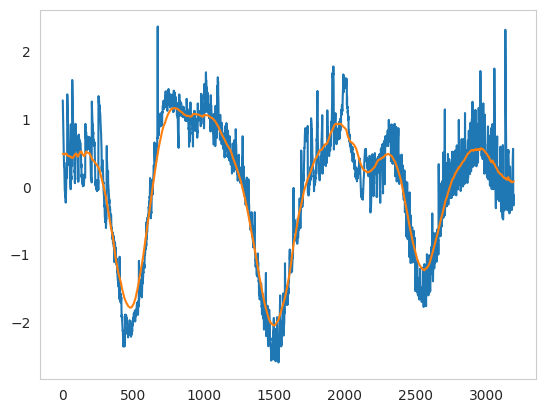

372


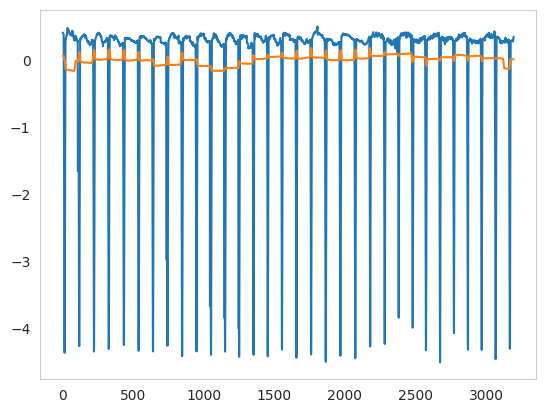

417


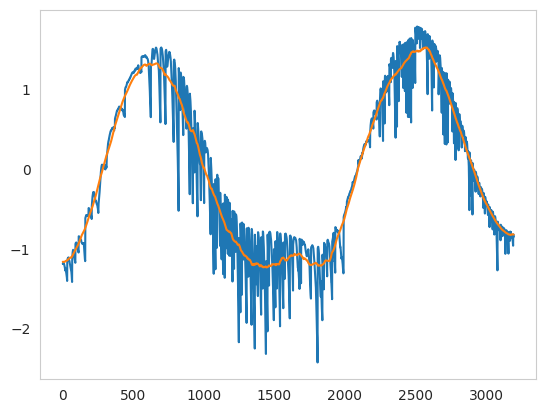

506


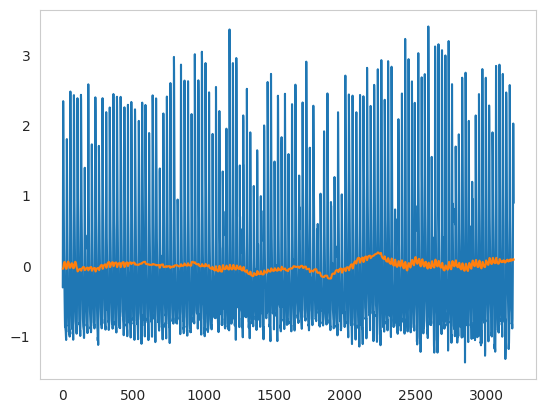

In [76]:
false_positives = np.where(y_hat * (1. - y_test) > 0.5)[0]
for i in non_idx:
    if y_hat[i] > crossover_cutoff:
        print(i)
        plt.plot(x_test[i])
        plt.grid(False)
        plt.show()